In [6]:
import sys
import glob
import yaml
import pyart
import joblib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.spatial.distance as dst
from matplotlib.colors import LinearSegmentedColormap

sys.path.append('../scripts')
import core
from analyse import aname, bname

In [5]:
win=100
nbasis=15
exp = 'nat8a'
dataset = 'alpha'

stim_info = pd.read_csv(f"../inputs/stimuli/{exp}-info.csv")
spectrograms = pd.read_csv(f"../build/{exp}/spectrograms.csv", index_col=[0,1])
motifs = stim_info.motif.unique()
gaps = stim_info[stim_info.type=='gap'].groupby(['motif','gap']).first()[['gap_start', 'gap_stop']]
gaplocs = gaps.index.levels[1].to_numpy().astype(int)
alpha_resps = pd.read_hdf(
    f"../build/{exp}/alpha_delemb_win{win}_basis{nbasis}.h5",
    key="Induction")    
models = joblib.load(f"../output/{exp}/{dataset}_PLS_models.pkl")
model = models['all']

In [16]:
projections = []
for m in motifs:
    cstim = spectrograms.loc[aname(m, 'C', None)]
    for g in gaplocs:
        ga, gb = gaps.loc[m].loc[g].astype(int)
        for c in ['C','G','CB', 'GB', 'N']:
            stim = aname(m, c, g)
            X = model.transform(
                X = alpha_resps.loc[stim].loc[ga:gb]
            )
            projections.append({
                'motif': m,
                'gap': g,
                'condition': c,
                'projections': X
            })
result = pd.DataFrame(projections).set_index(['motif', 'gap', 'condition'])

In [80]:
distmap = []
for i, (m, g) in enumerate(itertools.product(motifs, gaplocs)):
    CI_proj = result.loc[m, g, 'C'].projections[:,:3]
    CI_dist = [dst.euclidean(x, [-1,-0.5,-1]) for x in CI_proj]
    distmap.append({
        'motif':m,
        'gap':g,
        'avg': np.mean(CI_dist)
    })
distmap = pd.DataFrame(distmap).sort_values('avg')
distmap['distrank'] = np.arange(16)
distmap['viridiscolor'] = [mpl.colormaps['viridis'](x) for x in np.linspace(0,1,16)]
distmap.set_index(['motif','gap'], inplace=True)
distmap.head()

avg  distrank                         viridiscolor
motif gap                                                         
B189  2    0.743543         0  (0.267004, 0.004874, 0.329415, 1.0)
O129  2    0.788989         1   (0.282656, 0.100196, 0.42216, 1.0)
B30   1    0.866923         2  (0.277134, 0.185228, 0.489898, 1.0)
R253  1    0.904265         3  (0.253935, 0.265254, 0.529983, 1.0)
      2    0.964153         4  (0.221989, 0.339161, 0.548752, 1.0)

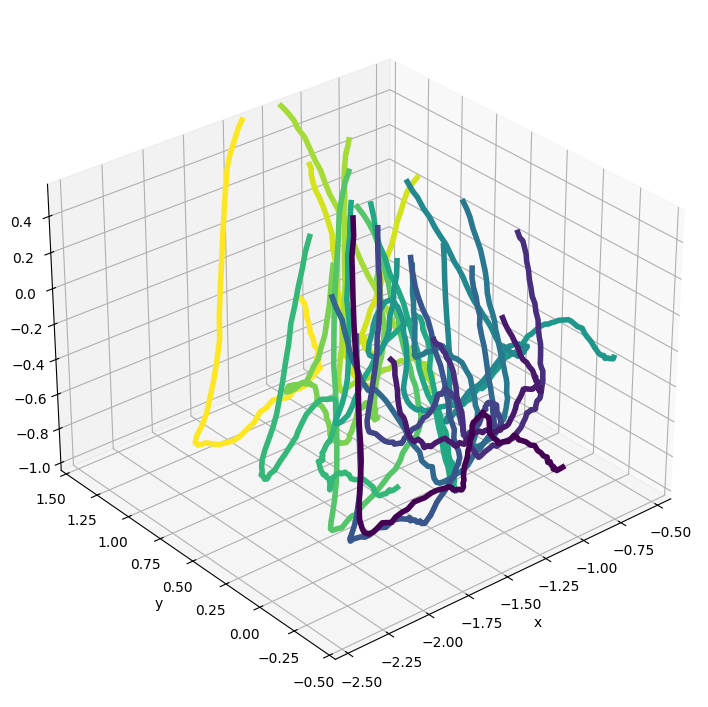

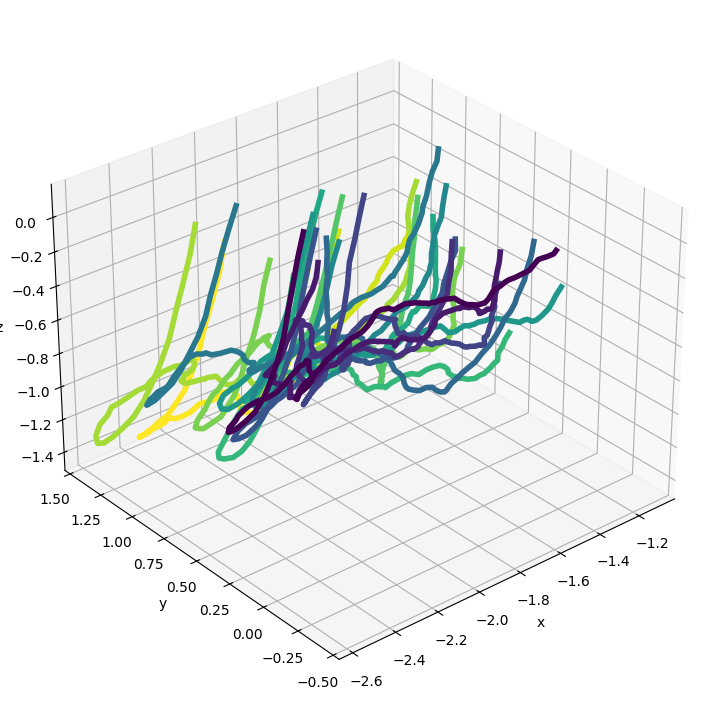

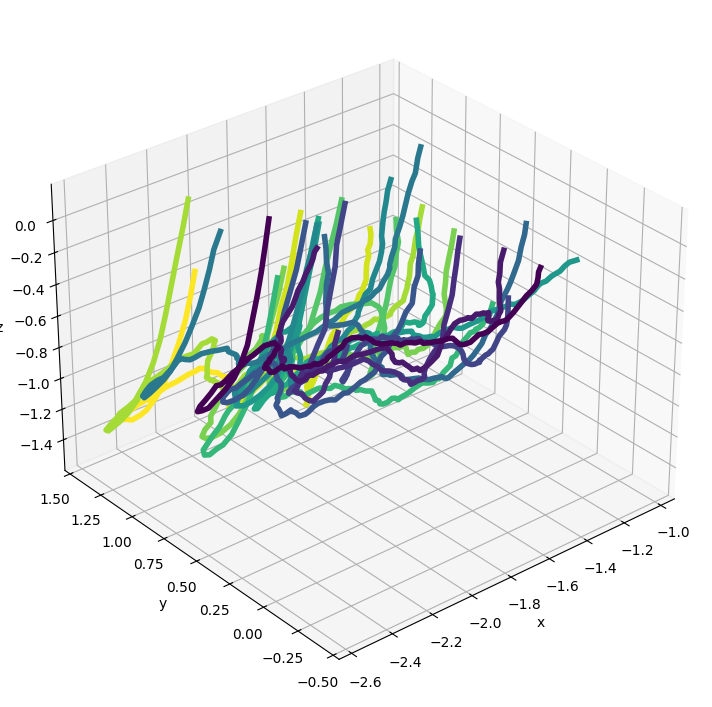

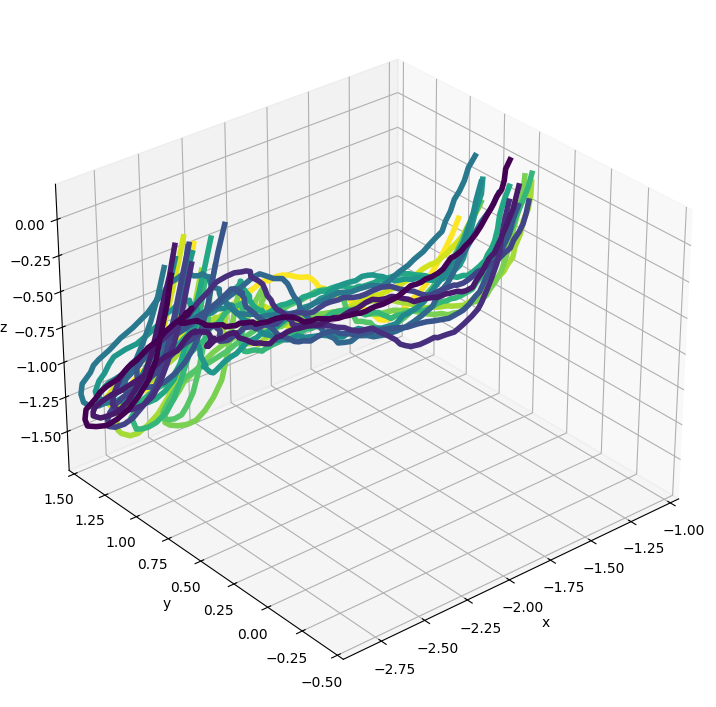

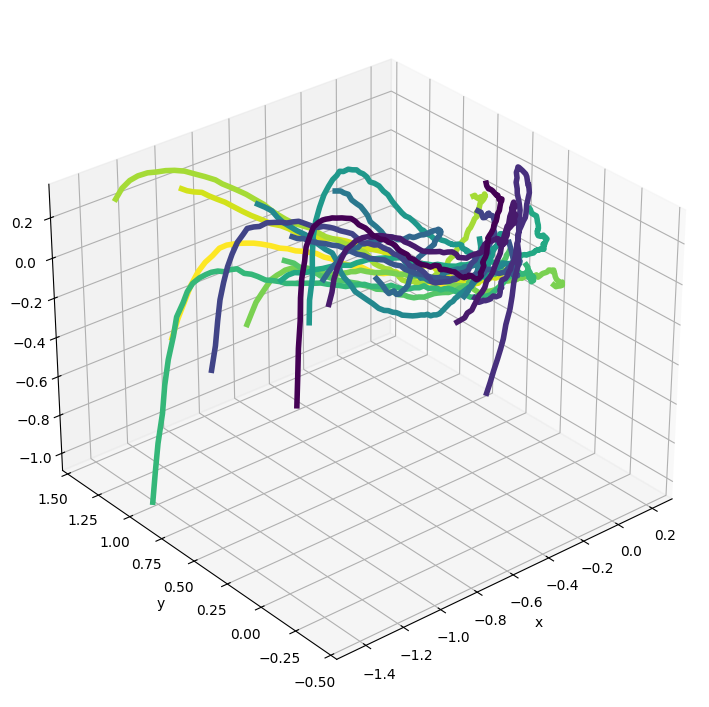

In [93]:
colbar = False
for c in ['C','CB','GB','N','G']:
#for c in ['C']:
    fig = plt.figure(figsize=(10,9))
    ax = fig.add_subplot(1,9,(2,9),projection='3d')
    plt.setp(ax.spines.values(), lw=3, color='black')
    for i, (m, g) in enumerate(distmap.index[::-1]):
        projs = result.loc[m, g, c].projections
        img = ax.plot(
            projs[:, 0],
            projs[:, 1],
            projs[:, 2],
            alpha=1,
            color= distmap.loc[m,g].viridiscolor,
            lw=4
        )
    ax.view_init(elev=30, azim=230, roll=0)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    # ax.set_xlim(1,4)
    # ax.set_xticks([2,3], [])
    ax.set_ylim(-0.5,1.5)
    #ax.set_yticks([-1,0,1], [])
    # ax.set_zlim(-1.5,0)
    # ax.set_zticks([-1,0], [])
    # ax.set_title(c)
    # if colbar:
    #     clbax = fig.add_subplot(1,9,1)
    #     gradient = np.linspace(0,1,16)
    #     gradient = np.vstack((gradient, gradient))
    #     clbax.imshow(gradient.T, cmap=cm, aspect=2)
    #     clbax.set_xticks([])
    #     clbax.set_yticks([])

In [35]:
def heatmap(data, x='GB', y='CB', centered=False, init=False):
    matrix = []
    for (m1, g1), mgdata1 in data.groupby(level=['motif', 'gap']):
        for (m2, g2), mgdata2 in data.groupby(level=['motif', 'gap']):
            proj_from = mgdata1.loc[m1, g1, x].projections
            proj_to = mgdata2.loc[m2, g2, y].projections
            distances = np.array([dst.euclidean(
                proj_from[t, :],
                proj_to[t, :]
            ) for t in np.arange(min(proj_from.shape[0], proj_to.shape[0]))])
            matrix.append({
                'from_m': m1,
                'from_g': g1,
                'to_m': m2,
                'to_g': g2,
                'dist': distances[0] if init else distances.mean()
            })
    heatmatrix = pd.DataFrame(matrix).set_index(['from_m', 'from_g', 'to_m', 'to_g']).unstack(['to_m', 'to_g'])
    return heatmatrix

In [37]:
GBC = heatmap(result, 'GB', 'C', centered=False)
GBCB = heatmap(result, 'GB', 'CB', centered=False)
GBGB = heatmap(result, 'GB', 'GB', centered=False)
GBN = heatmap(result, 'GB', 'N', centered=False)

In [ ]:
sns.set_style('white')
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 2

plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 2

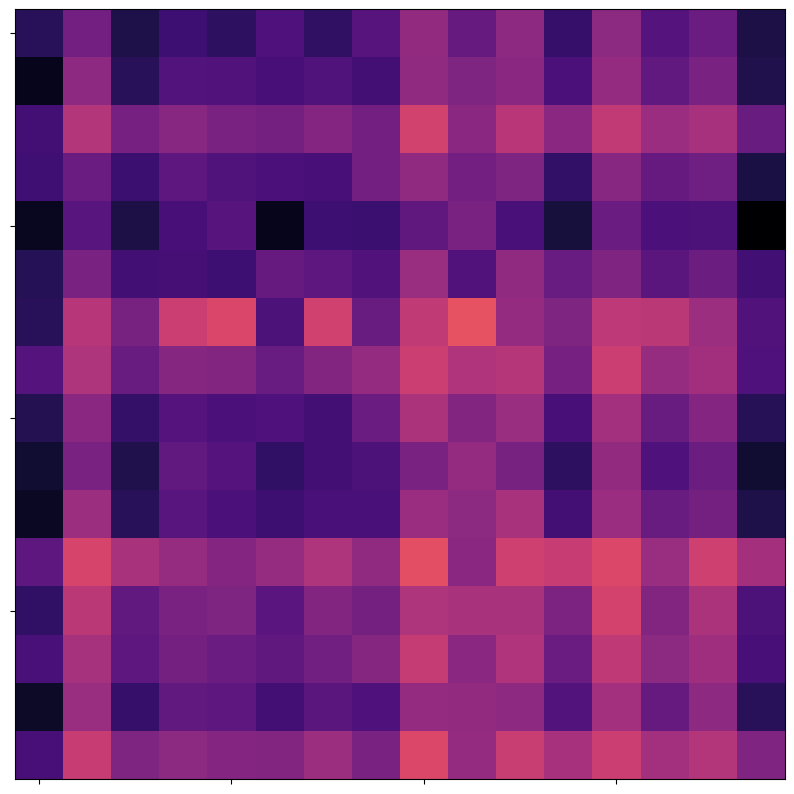

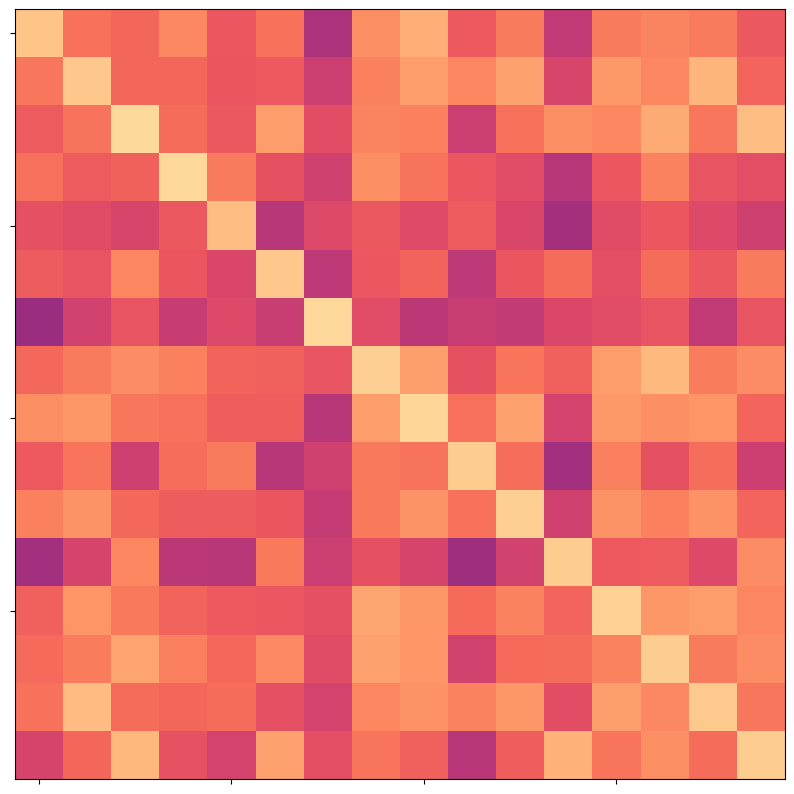

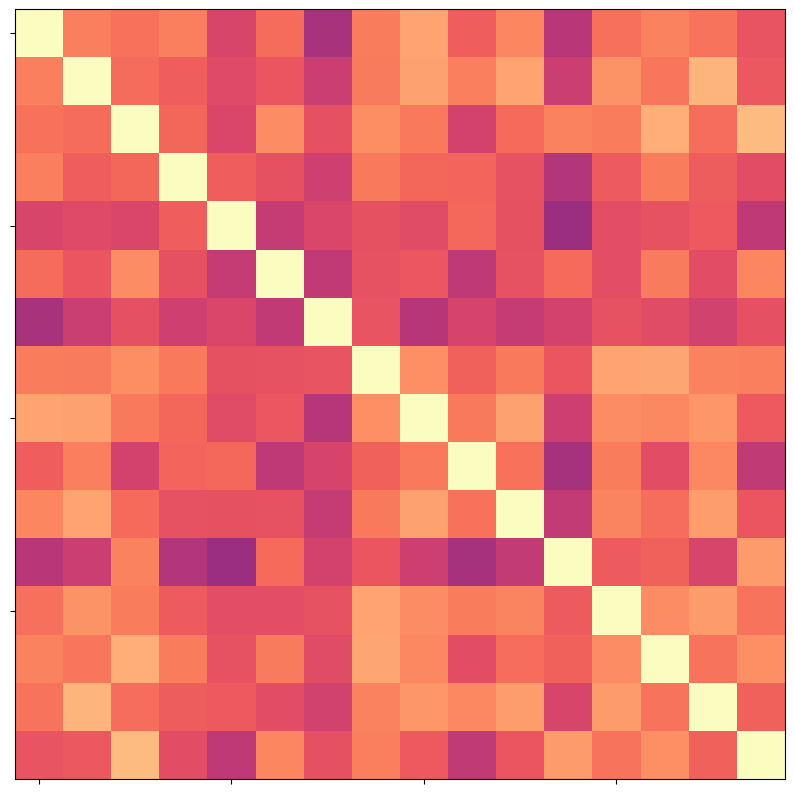

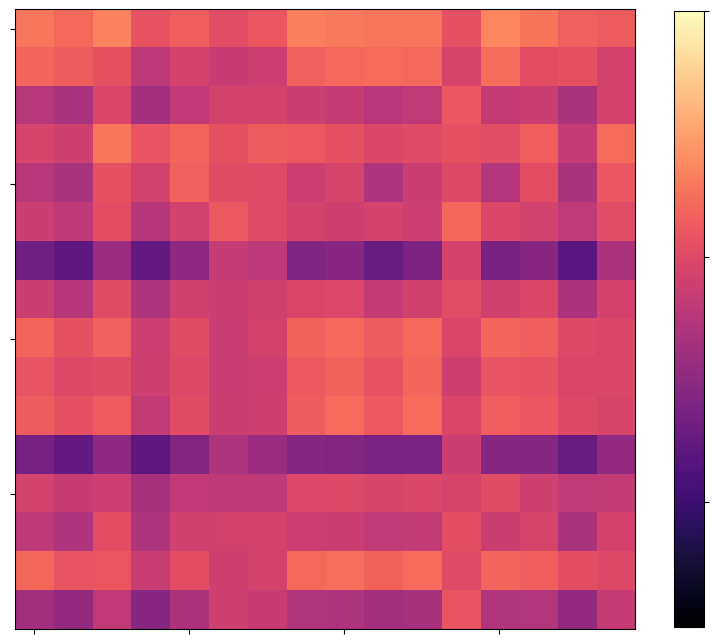

In [39]:
heatmax = np.max([
    GBC.max(axis=None),
    GBCB.max(axis=None),
    GBGB.max(axis=None),
    GBN.max(axis=None),
])
heatmin = np.min([
    GBC.min(axis=None),
    GBCB.min(axis=None),
    GBGB.min(axis=None),
    GBN.min(axis=None),
])
for matrix in [GBC, GBCB, GBGB, GBN]:
    ax = plt.figure(figsize=(10,10)).add_subplot()
    img = ax.imshow(matrix*-1, vmin=heatmax*-1, vmax=heatmin*-1, cmap='magma')
    ax.set_xticks(np.arange(0,16,4), [])
    ax.set_yticks(np.arange(0,16,4), [])
cbar = plt.colorbar(img,
                    ticks=[0,-1,-2],
                    format=mpl.ticker.FixedFormatter(['','','']),
                    shrink=0.8)

In [41]:
def export(df, exp, tag):
    export_data = df.stack([1,2], future_stack=True).reset_index(drop=False)
    export_data['same_CI'] = export_data.apply(
        lambda row: (row.from_m==row.to_m)&(row.from_g==row.to_g),
        axis=1)
    export_data['exp'] = 'nat8a'
    export_data['GB_to'] = tag
    return export_data
    
pd.concat([
    export(GBC, 'nat8a', 'C'),
    export(GBCB, 'nat8a', 'CB'),
    export(GBN, 'nat8a', 'N'),    
]).to_csv('../output/pairwise-nat8a-alpha-unified.csv')